# Tutorial

Jelle, updated May 2020

updated Feb 2022 by Joran

This notebook shows how to do basic analysis with straxen, much like `hax.minitrees`.

For reference, here are some jargon terms which we will introduce below:

  * **Context**: Holds configuration on how to process
  * **Dataframe** or **array**: table of related information produced by a plugin.
  * **Plugin**: an algorithm that produces a dataframe
  * **Data type**: specification of which columns are in a dataframe. 
  * **Data kind**: e.g. 'events' or 'peaks'. Dataframes of the same kind  have the same number of rows and can be merged.


In [1]:
import numpy as np
import pandas as pd
# This just ensures some comments in dataframes below display nicely
pd.options.display.max_colwidth = 100
import straxen

In [2]:
straxen.print_versions()

cutax is not installed


,module,version,path,git
0,python,3.10.0,/home/angevaare/miniconda3/envs/dev_strax/bin/python,None
1,strax,1.1.7,/home/angevaare/software/dev_strax/strax/strax,branch:master | db14f80
2,straxen,1.2.8,/home/angevaare/software/dev_strax/straxen/straxen,branch:master | 024602e


## Setting up

First we load a strax **context**, much like `hax.init()`. A strax context contains all information on *how* to process: where to read what files from, what plugins provide what data, etc. 

You can make a context yourselves using `strax.Context`, but straxen provides standardized contexts as well. Most future analyses will use such standardized contexts defined by analysis coordinators or straxen maintainers.

Unlike `hax.init`, you can have multiple active contexts, e.g. to load analysis and MC data, or compare data processed with different settings (we will see examples of this below).

In [3]:
st = straxen.contexts.xenonnt_online()

## Finding your data

Suposse we want to make a cS1/cS2 plot. We have to figure out which type of **dataframes** to load. A specific type of dataframe is also called a **data type**. (in hax these were called minitrees)

We can find this out automatically if we know (part of) the name of a field to load:

In [4]:
st.search_field('cs1')


cs1 is part of corrected_areas (provided by CorrectedAreas)
cs1 is part of event_info (provided by EventInfo)

cs1 is used in CorrectedAreas.infer_dtype
cs1 is used in CorrectedAreas.compute
cs1 is used in EnergyEstimates.compute
cs1 is used in EnergyEstimates.cs1_to_e


It seems we're after one of the data types called `event_info` or `corrected_areas`. In the current context, these are provided by **plugins** called EventInfo and CorrectedAreas, respectively (but this doesn't concern us yet). 

Additionally, we see the occurrences of `cs1` of a field in `EnergyEstimates` and `CorrectedAreas`. This means that the field is used there directly

Let's see what else is in these data types:

In [5]:
st.data_info('event_info')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,endtime,int64,Exclusive end time since unix epoch [ns]
2,cs1,float32,Corrected area of main S1 [PE]
3,cs2_wo_elifecorr,float32,Corrected area of main S2 before elife correction (s2 xy correction + SEG/EE correction applied)...
4,cs2_wo_timecorr,float32,Corrected area of main S2 before SEG/EE and elife corrections(s2 xy correction applied) [PE]
...,...,...,...
106,z_naive,float32,Interaction z-position using mean drift velocity only (cm)
107,r_naive,float32,Interaction r-position using observed S2 positions directly (cm)
108,r_field_distortion_correction,float32,Correction added to r_naive for field distortion (cm)
109,z_field_distortion_correction,float32,Correction added to z_naive for field distortion (cm)


As you can see, `event_info` has a lot more information; let's load that one. You can see from the documentation (TODO link) that `event_info`'s job is to merge the info from `corrected_areas` and other things.


## Loading data

Next, you'll want to select a run. The `select_runs` function will return a dataframe with all available runs; there is a separate tutorial on more advanced use of this. In this demo context, we only have high-level data for the run `180215_1029` available (and low-level data for another):

In [ ]:
st.select_runs()

So lets' take 021932.

To actually load data, you use `get_df` to get a pandas DataFrame, or `get_array` to get a numpy (structured) array. Let's go with pandas for now:

In [6]:
run_id = '021932'
# The seconds_range=[0,60] is an optional argument to prevent loading too much data at once
df = st.get_df(run_id, 'event_info', seconds_range=[0,60])

Loading event_info: |          | 0.00 % [00:00<?]

The first time you run this, it will take a moment: it has to actually process the data somewhat. We didn't ship highest-level demo data with straxen: that would mean we'd have to constantly update the test data when the algorithms change.

You can also specify a list of runid's instead of one run, and get the concatenated result back. Likewise, you can specify multiple data types (of the same kind) to load, and they will be merged for you.

Just like hax.minitrees.load, we got a dataframe back:

In [7]:
st.show_config('event_info')

,option,default,current,applies_to,help
0,gain_model,<OMITTED>,"(to_pe_model, ONLINE, True)","(afterpulses,)","PMT gain model. Specify as (model_type, model_config)"
1,n_tpc_pmts,<OMITTED>,494,"(afterpulses,)",Number of PMTs in TPC
2,LED_window_left,50,<OMITTED>,"(afterpulses,)",Left boundary of sample range for LED pulse integration
3,LED_window_right,100,<OMITTED>,"(afterpulses,)",Right boundary of sample range for LED pulse integration
4,baseline_samples,40,<OMITTED>,"(afterpulses,)",Number of samples to use at start of WF to determine the baseline
...,...,...,...,...,...
269,recon_alg_included,"(_mlp, _gcn, _cnn)",<OMITTED>,"(s2_recon_pos_diff,)",The list of all reconstruction algorithm considered.
270,max_veto_window,7200000000000,<OMITTED>,"(veto_intervals,)",Maximum separation between veto stop and start pulses [ns]. Set to be >> than the max duration o...
271,event_window_fields,"(time, endtime)",<OMITTED>,"(veto_proximity,)",Fields to determine where to look for overlaps for using this plugin in the events. The default ...
272,veto_proximity_window,300000000000,<OMITTED>,"(veto_proximity,)",Maximum separation between veto stop and start pulses [ns]


In [8]:
df.head()

,time,endtime,cs1,cs2_wo_elifecorr,cs2_wo_timecorr,cs2_area_fraction_top,cs2_bottom,cs2,alt_cs1,alt_cs2_wo_elifecorr,...,alt_s2_y_mlp,x,y,z,r,z_naive,r_naive,r_field_distortion_correction,z_field_distortion_correction,theta
0,1623144887003148092,1623144887005863030,2.659672,348.436493,370.887268,0.777278,82.604637,370.887268,NaN,34.098747,...,-23.990379,-7.353356,-15.314320,-43.339104,16.988239,-43.339104,16.190155,0.798083,0.007348,-2.018448
1,1623144887006147772,1623144887008854250,13155.237305,NaN,NaN,NaN,NaN,NaN,4.279365,NaN,...,NaN,45.517769,55.207436,-0.189628,71.552284,-0.189628,69.542831,2.009451,0.000000,0.881302
2,1623144887030319882,1623144887033327360,61723.960938,28599.917969,29029.152344,0.723225,8034.542969,29029.152344,19.304628,1338.243530,...,53.898460,-35.264309,55.141556,-10.200156,65.453514,-10.200156,61.628628,3.824886,0.744288,2.139771
3,1623144887054958322,1623144887057677700,76545.257812,1266.177612,1266.558594,0.159955,1063.966309,1266.558594,2.062342,17.207802,...,2.884162,31.293451,9.913309,-0.026945,32.826115,-0.026945,37.803139,-4.977024,0.000000,0.306784
4,1623144887127075472,1623144887129777490,NaN,5178.317383,NaN,0.749424,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,61.323208,NaN,NaN,2.864871


Let's make a quick plot of the events we just loaded:

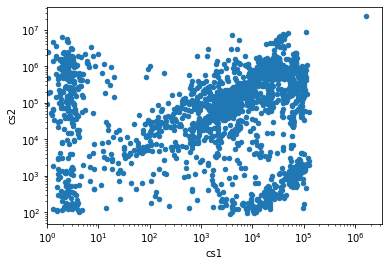

In [9]:
df.plot.scatter('cs1', 'cs2')

import matplotlib.pyplot as plt
plt.xscale('log')
plt.xlim(1, None)
plt.yscale('log')

Since making a cS1, cS2 plot for a dataset is such a common task that straxen has a built-in method for it. There are other similar mini-analyses, such a waveform plotting, which we will see in action below.

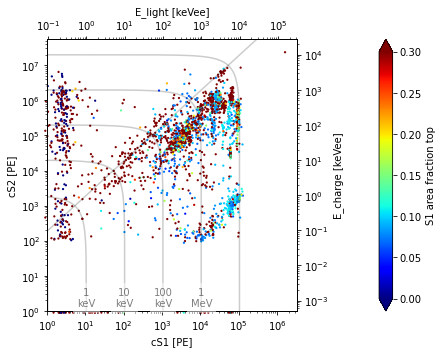

In [10]:
st.event_scatter(run_id, s=20, seconds_range=[0,60])

Can you guess what kind of data this is?

## Waveform analysis

The *peaks* data type contains the sum waveform information:

In [11]:
st.data_info('peaks')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int32,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,type,int8,Classification of the peak(let)
5,area,float32,Integral across channels [PE]
6,area_per_channel,"('<f4', (494,))",Integral per channel [PE]
7,n_hits,int32,Number of hits contributing at least one sample to the peak
8,data,"('<f4', (200,))",Waveform data in PE/sample (not PE/ns!)
9,width,"('<f4', (11,))",Peak widths in range of central area fraction [ns]


Notice the compound data types of the `data`, `width` and `saturated_channel` fields. Pandas does not support such types (well, it sort of does, but the resulting dataframes are quite inefficient), so we have to load this as a numpy array.

In [12]:
peaks = st.get_array(run_id, 'peaks', seconds_range=[0,60])
type(peaks), peaks.dtype.names

Loading peaks: |          | 0.00 % [00:00<?]

(numpy.ndarray,
 ('time',
  'length',
  'dt',
  'channel',
  'type',
  'area',
  'area_per_channel',
  'n_hits',
  'data',
  'width',
  'area_decile_from_midpoint',
  'saturated_channel',
  'n_saturated_channels',
  'tight_coincidence',
  'max_gap',
  'max_goodness_of_split'))

Now we can plot peak waveforms:

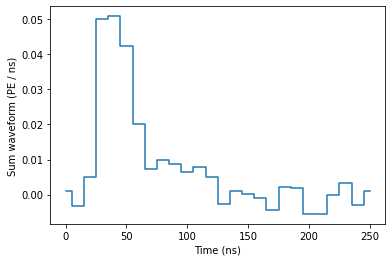

In [13]:
def plot_peak(p, t0=None, **kwargs):
    n = p['length']
    if t0 is None:
        t0 = p['time']
    plt.plot((p['time'] - t0) + np.arange(n) * p['dt'], 
             p['data'][:n] / p['dt'], 
             drawstyle='steps-mid',
             **kwargs)
    plt.xlabel("Time (ns)")
    plt.ylabel("Sum waveform (PE / ns)")

plot_peak(peaks[148])
plt.show()

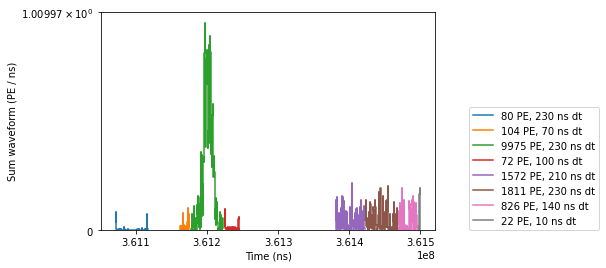

In [14]:
def plot_peaks(main_i, n_before=0, n_after=0, label_threshold=0, legendloc='best'):
    for i in main_i + np.arange(-n_before, n_after + 1):
        p = peaks[mask][i]
        label = None
        if p['area'] > label_threshold:
            label = '%d PE, %d ns dt' % (p['area'], p['dt'], )
            color = None
        else:
            color = 'gray'
        plot_peak(p,
                  t0=peaks[main_i]['time'],
                  label=label,
                  color=color)
    plt.ylim(0, None)
    plt.legend(loc=legendloc)
    plt.yscale('symlog')

# Find the largest peak close to 1e4 PE
mask=peaks['area']<1e4
i_of_largest_peak = np.argmax(peaks[mask]['area'])
plot_peaks(i_of_largest_peak,
           n_after=5, 
           n_before=2, 
           label_threshold=10, 
           legendloc=(1.1, 0.0))

The abrupt termination of the S2 above is due to strax's data reduction.

If you have access to the raw data (at least the `records` level) you can use straxen's built-in waveform display. For example, try:

```python
st.waveform_display(run_id, seconds_range=(0, 0.15))
```

(we didn't evaluate this in the tutorial, as it creates a substantial amount of javascript, which would have made the notebook quite huge).

## Configuration changes

As you can see in the above plot, we have many events high up in the TPC at low S1. Perhaps you want to get rid of them by increasing the 'S1 coincidence requirement', i.e. the number of PMTs that must see something before a peak is labeled as S1. Then, of course, you want to load the event-level data again to see if it worked.

First, we need to see which configuration option we have to change. Strax plugins declare what configuration they take and what other plugins they depend on, so this is not very difficult. We just ask which options with `s1` in their name influence `event_basics`:

In [29]:
st.show_config('event_basics', 's1*')[['option', 'applies_to', 'help', 'current', 'default']]

,option,applies_to,help,current,default
0,s1_xyz_map,"(corrected_areas,)",,<OMITTED>,itp_map://resource://cmt://format://s1_xyz_map_{algo}?version=ONLINE&run_id=plugin.run_id&fmt=js...
1,s1_risetime_area_parameters,"(peaklet_classification,)","norm, const, tau in the empirical boundary in the risetime-area plot",<OMITTED>,"(50, 80, 12)"
2,s1_risetime_aft_parameters,"(peaklet_classification,)",Slope and offset in exponential of emperical boundary in the rise time-AFT plot. Specified as (s...,<OMITTED>,"(-1, 2.6)"
3,s1_flatten_threshold_aft,"(peaklet_classification,)","Threshold for AFT, above which we use a flatted boundary for rise timeSpecified values: (AFT bou...",<OMITTED>,"(0.6, 100)"
4,s1_max_rise_time_post100,"(peaklet_classification,)",Maximum S1 rise time for > 100 PE [ns],<OMITTED>,200
5,s1_min_coincidence,"(peaklet_classification,)",Minimum tight coincidence necessary to make an S1,<OMITTED>,2
6,s1_optical_map,"(event_pattern_fit,)","S1 (x, y, z) optical/pattern map.",<OMITTED>,XENONnT_s1_xyz_patterns_LCE_corrected_qes_MCva43fa9b_wires.pkl
7,s1_aft_map,"(event_pattern_fit,)",Date drive S1 area fraction top map.,<OMITTED>,s1_aft_dd_xyz_XENONnT_Kr83m_41500eV_31Oct2021.json
8,s1_min_area_pattern_fit,"(event_pattern_fit,)",Skip EventPatternFit reconstruction if S1 area (PE) is less than this,<OMITTED>,2
9,s1_risetime_area_parameters,"(peaklet_classification_he,)","norm, const, tau in the empirical boundary in the risetime-area plot",<OMITTED>,"(50, 80, 12)"


Looks like we're after the `s1_min_coincidence option`. Note this is not part of the `event_basics` data type, but of a data type called `peak_classification`. As you can see from the table, this option is not set in the current context, so the default value (3) is used.

To try out a different option, just pass it to get_df:

In [30]:
# Let's use a short run for the following exaples
run_id='038769'

Loading event_info: |          | 0.00 % [00:00<?]

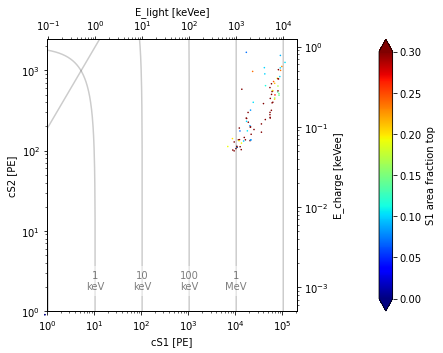

In [31]:
st2 = st.new_context()
st2.set_config(dict(s1_min_coincidence=50))
df_2 = st2.get_df(run_id, 'event_info',
                 config=dict(s1_min_coincidence=50),
                )
st2.event_scatter(run_id, events=df_2)

Notice all the small S1 events are indeed gone now.

Behind the scenes, this figured out which dataframes had to be remade: as it happens this time just `event_basics` and `peak_basics`. You will now have a new `event_basics_<somehash>` folder in `./custom_data` which contains the results, as well as a new `peak_basics_<somehash> folder`.

### More on configuration changes

Changing configuration can be done in two other ways. We can change it permanently in the current context:
```python
st.set_config(dict(s1_min_coincidence=50))
```
Or we could make a new context, with this option set:
```python
st_2 = st.new_context(config=dict(s1_min_coincidence=50))
```
(feeding it to get_df just does the latter behind the scenes).

If you just want to run a mini-analysis (like `event_scatter`), you can also pass a new `config` option directly to it, as in the example below.

Strax protects you from typos in the configuration. Suppose we typed `s1_min_n_channelz` instead:

In [32]:
st.event_scatter(run_id, config=dict(s1_min_n_channelz=10), seconds_range=[0,60])

Option s1_min_n_channelz not taken by any registered plugin
Option s1_min_n_channelz not taken by any registered plugin


DataNotAvailable: Time range selection assumes data is already available, but event_info for 038769 is not.

The result of get_df is just the same as if the option wasn't set (just like in pax/hax), but you also get a warning about an unknown configuration option. 

By the way, you can use 
```python
import warnings
warnings.filterwarnings("error")
```
to ensure any warning raises an exception instead.

## Customization: new plugins

To add or change processing algorithms, or to define new variables to use in cuts, you have to write new strax plugins. These are somewhat similar to hax's treemakers.

Suppose you have a brilliant new idea for peak classification. Strax does this in the peaklet_classification plugin, which produces:

In [33]:
st.data_info('peaklet_classification')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int32,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,type,int8,Classification of the peak(let)


  * The first three fields contain time information of the peak. This is duplicated in many datatypes -- unfortunately, this is necessary for strax to be able to track the data and combine it with other data. Instead of (time, length, dt), plugins could also provide (time, endtime). See [here](https://strax.readthedocs.io/en/latest/advanced/plugin_dev.html#special-time-fields) for more information.
  * The 'channel' field is an historical artifact.
  * The 'type' field contains the classification: 0 for unknown, 1 for S1, 2 for S2. (note [#8](https://github.com/XENONnT/straxen/issues/8))
  
You can find the original plugin in [peaklet_processing.py](https://github.com/XENONnT/straxen/blob/master/straxen/plugins/peaklet_processing.py.) Here's how you would make a different classification plugin:

In [34]:
import strax
import numpy as np

class AdvancedExpertClassification(strax.Plugin):
    """Everything is an S1!"""
    
    # Name of the data type this plugin provides
    provides = 'peaklet_classification'
    
    # Data types this plugin requires. Note we don't specify
    # what plugins should produce them: maybe the default PeakBasics
    # has been replaced by another AdvancedExpertBlabla plugin?
    depends_on = ('peaklets',)
    
    # Numpy datatype of the output 
    dtype = straxen.PeakletClassification.dtype
    
    # Version of the plugin. Increment this if you change the algorithm.
    __version__ = '0.0.2'

    def compute(self, peaklets):
        # Your code here.
        # This function will be called several times with 
        # 'peaks' a numpy array of the datatype 'peaks'.
        # Each time you'll see a small part of the run.
        
        # You have to return a numpy array of the dtype you declared above
        result = np.zeros(len(peaklets), self.dtype)
        
        # Copy the basic time fields over from peaklets
        for (_, field), _ in strax.time_dt_fields:
            result[field] = peaklets[field]
            
        # Store the classification results
        # You might want to do real work here
        result['type'] = 1
        
        return result
        
        # Instead of an array, you are also allowed to return a dictionary 
        # we can transform into an array.
        # That is, (dict keys -> field names, values -> field values)

To use it in place of PeakClassification, we only have to register it. Again, we can do so permanently using 
```python
st.register(AdvancedExpertClassification)
```
or temporarily, by feeding the registration as an extra argument to `get_df`:

In [35]:
df = st.get_df(run_id, 'event_info',
               register=AdvancedExpertClassification,
              )

Loading event_info: |          | 0.00 % [00:00<?]

Found chunk without events?!
Found chunk without events?!
Found chunk without events?!


In [36]:
df['s2_area'].max()

nan

As you can see, all events are now S1-only events, as expected. Maybe this is not the best alternative classification :-)

This plugin was a rather basic plugin. You'll also want to learn about `LoopPlugin`s and `OverlapWindowPlugin`s, but that's beyond the scope of this tutorial.